# Monte Carlo Uncertainty Analysis for Nonlinear Regression

CBE 20258. Numerical and Statistical Analysis. Spring 2020.

&#169; University of Notre Dame

In [2]:
# load libraries
import scipy.stats as stats
import numpy as np
import scipy.optimize as optimize
import math
import matplotlib.pyplot as plt

## Simulation

**Further Reading:** §4.12

Consider two resistors in parallel with resistances $X \sim \mathcal{N}(10~\Omega,~10^2~\Omega^2)$ and $Y \sim \mathcal{N}(25~\Omega,~2.5^2~\Omega^2)$. The total resistance of the circuit is

$$R = \frac{X Y}{X + Y}$$

Assume $X$ and $Y$ are independent.

What is $P(19~\Omega \leq X \leq 21~\Omega)$, i.e., the probability the circuit is within specification?

<div style="background-color: rgba(0,0,255,0.05) ; padding: 10px; border: 1px solid darkblue;"> 
<b>Class Activity</b>: Spend 3 minutes with a partner outlining your solution strategy using probability theory. First, write down the main steps. Then, if you have time, write down the formulas.
</div>

### Using Simulation to Estimate a Probability

Intead of all of that calculus, we can use simulation to estimate this probability.

Repeat 1000s of times:
* Generate X and Y using a random number generator
* Compute $R$ and record the value

In [3]:
# specify number of simulations
nsim = 1000

# create vector to store the results
R_sim = np.zeros(nsim)


# create normally distributed noise
# loc = mean
# scale = standard deviation
x = np.random.normal(loc = 100, scale = 10, size=(nsim))
y = np.random.normal(loc = 25, scale=2.5, size=(nsim))
    
# calculate a1, store result
R_sim = x * y / (x + y)

<div style="background-color: rgba(0,0,255,0.05) ; padding: 10px; border: 1px solid darkblue;"> 
<b>Class Activity</b>: Estimate $P(19~\Omega \leq X \leq 21~\Omega)$ using your simulation results.
</div>

### Using Simulation to Estimate Means and Variances

In [4]:
# print some descriptive statistis
print("Mean: ",np.mean(R_sim)," Ohms")
print("Median: ",np.median(R_sim)," Ohms")
print("Standard Deviation: ",np.std(R_sim,ddof=1)," Ohms")

Mean:  19.814933102457328  Ohms
Median:  19.820608436088186  Ohms
Standard Deviation:  1.729237724968207  Ohms


### Using Simulation to Determine Whether a Population is Approximately Normal

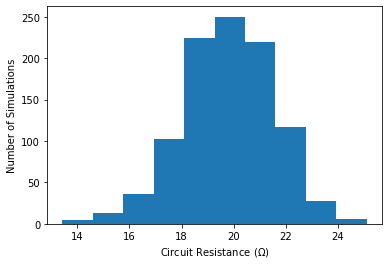

In [5]:
# create histogram of calculated a1 values
plt.hist(R_sim)
plt.xlabel("Circuit Resistance ($\Omega$)")
plt.ylabel("Number of Simulations")
plt.show()

## Monte Carlo Error Propagation

**Further Reading:** §4.12

### Motivating Example: Cart + Incline

You and a classmate want to measure the acceleration of a cart rolling down an incline plane, but disagree on the best approach. The cart starts at rest and travels distance $l = 1.0$ m. The location of the *finish line* is measured with negligible uncertainty. You (student 1) measure the instantaneous velocity $v = 3.2 \pm 0.1 $ m/s at the finish line. Your classmate (student 2) instead measures the elapsed time $t = 0.63 \pm 0.01$s.


#### Student 1

Using instantaneous velocity, we can acceleration as follows:

$$
a_1 = \frac{v^2}{2l}
$$

First, let's recap the *standard* error propagation approach from our homework.

##### Standard Error Propagation

In [6]:
## Results of 'standard' error analysis (from homework)

# define distance travelled
l = 1 # m 

# define function to calculate a1
calc_a1 = lambda v: v**2 / (2*l)

# define velocity measurement and uncertainty
v = 3.2
v_std = 0.1

# calculate a1
a1 = calc_a1(v)

# estimate gradient with forward finite difference
da1dv = (calc_a1(v + 1E-6) - a1)/(1E-6)

# calculate uncertainty
sigma_a1 = abs(da1dv)*v_std

# report answer
print("Calculated acceleration: ",round(a1,2),"+/-",round(sigma_a1,2),"m/s/s")

Calculated acceleration:  5.12 +/- 0.32 m/s/s


##### Monte Carlo Error Propagation

We can also estimate the uncertainty in $a_1$ using simulation. Below is the **main idea**.

Repeat 1000s of times:
* Add $\mathcal{N}(0,0.1^2)$ uncertainty to velocity measurement
* Recalculate $a_1$ and store result

Then calculate the standard deviation of the stored $a_1$ results. In other words, we are simulated what would happen if we repeated the experiment many many times with an assumed random measurement error.

<div style="background-color: rgba(0,0,255,0.05) ; padding: 10px; border: 1px solid darkblue;"> 
<b>Class Activity</b>: With a partner, complete the code below.
</div>

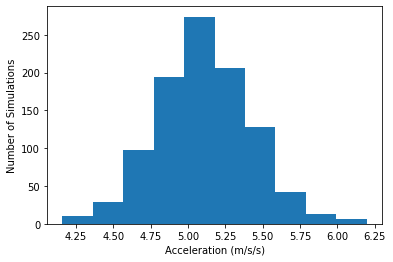

Mean:  5.109382327325115  m/s/s
Median:  5.090340839299156  m/s/s
Standard Deviation:  0.31552727670053443  m/s/s


In [7]:
# specify number of simulations
nsim = 1000

# create vector to store the results
a1_sim = np.zeros(nsim)

### BEGIN SOLUTION

# repeat many times
for i in range(0,nsim):
    
    # create normally distributed noise
    # loc = mean
    # scale = standard deviation
    noise = np.random.normal(loc = 0,scale = v_std)
    
    # calculate a1, store result
    a1_sim[i] = calc_a1(v + noise)

### END SOLUTION
    
# create histogram of calculated a1 values
plt.hist(a1_sim)
plt.xlabel("Acceleration (m/s/s)")
plt.ylabel("Number of Simulations")
plt.show()

# print some descriptive statistis
print("Mean: ",np.mean(a1_sim)," m/s/s")
print("Median: ",np.median(a1_sim)," m/s/s")
print("Standard Deviation: ",np.std(a1_sim)," m/s/s")

This standard deviation matches the uncertainty calculated with the error propagation formulas.

#### Student 2

Using instantaneous velocity, we can calculate acceleration as follows:

$$
a_2 = \frac{2 l}{t^2} 
$$

First, lets recap the solution to the homework.

##### Standard Error Propagation

In [8]:
## Results of 'standard' error analysis (from homework)

# define distance travelled
l = 1 # m

# define function to calculate a2
calc_a2 = lambda t: 2*l / t**2

# define time measurement and uncertainty
t = 0.63
t_std = 0.01

# calculate a2
a2 = calc_a2(t)

# estimate gradient with forward finite difference
da2dt = (calc_a2(t + 1E-6) - a2)/(1E-6)

# calculate uncertainty
sigma_a2 = abs(da2dt)*t_std

print("Calculated acceleration: ",round(a2,2),"+/-",round(sigma_a2,2),"m/s/s")

Calculated acceleration:  5.04 +/- 0.16 m/s/s


##### Monte Carlo Error Propagation

<div style="background-color: rgba(0,0,255,0.05) ; padding: 10px; border: 1px solid darkblue;"> 
<b>Class Activity</b>: Apply the Monte Carlo approach to Student 2's calculation. Start by copying and pasting the code from above.
</div>

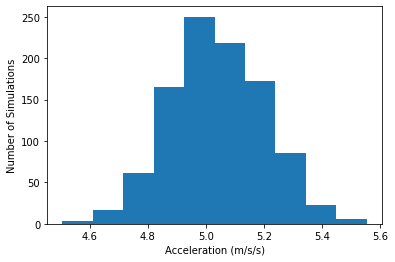

Mean:  5.039422830681053  m/s/s
Median:  5.032384952828478  m/s/s
Standard Deviation:  0.16032286655071076  m/s/s


In [9]:
### BEGIN SOLUTION

# specify number of simulations
nsim = 1000

# create vector to store the results
a2_sim = np.zeros(nsim)

# repeat many times
for i in range(0,nsim):
    
    # create normally distributed noise
    # loc = mean
    # scale = standard deviation
    noise = np.random.normal(loc = 0,scale = t_std)
    
    # calculate a1, store result
    a2_sim[i] = calc_a2(t + noise)
    
# create histogram of calculated a1 values
plt.hist(a2_sim)
plt.xlabel("Acceleration (m/s/s)")
plt.ylabel("Number of Simulations")
plt.show()

# print some descriptive statistis
print("Mean: ",np.mean(a2_sim)," m/s/s")
print("Median: ",np.median(a2_sim)," m/s/s")
print("Standard Deviation: ",np.std(a2_sim)," m/s/s")

### END SOLUTION

### Uncertainty Analysis for Nonlinear Regression

#### Motivating Example: Michaelis-Menten Enzymatic Reaction Kinetics

The **Michaelis-Menten** equation is an extremely popular model to describe the rate of enzymatic reactions.

$$
\mathrm{E} + \mathrm{S} \leftrightharpoons \mathrm{ES} \rightarrow \mathrm{E} + \mathrm{P}
$$

$$
r = V_{max} \frac{[\mathrm{S}]}{K_M + [\mathrm{S}]}
$$

Additional information: https://en.wikipedia.org/wiki/Michaelis%E2%80%93Menten_kinetics

In [10]:
## Create dataset

# Define exact coefficients
Vmaxexact=2;
Kmexact=5;

# Evaluate model
Sexp = np.array([.3, .4, 0.5, 1, 2, 4, 8, 16]);
rexp = Vmaxexact*Sexp / (Kmexact+Sexp);

# Add some random error to simulate 
rexp += 0.05*np.random.normal(size=len(Sexp))

# Evaluate model to plot smooth curve
S = np.linspace(np.min(Sexp),np.max(Sexp),100)
r = Vmaxexact*S / (Kmexact+S)

#### Nonlinear Regression + Linearized Uncertainty Analysis

**Main idea**: Solve the best fit optimization problem,

$$\min_{\hat{\theta}} \quad (y_i - \hat{y}_i)^2$$

computationally. This works even if $\hat{y_i} = f(\hat{\theta}, x)$ is a nonlinear function.

Recall $\theta$ = [$V_{max}$, $K_m$] for our example.


##### Step 1. Calculate Best Fit and Plot

In [11]:
## define function that includes nonlinear model
def model(theta,x):
    '''
    Michaelis-Menten model
    Arguments:
        theta: parameter vector
        x: independent variable vector (S concentration)
    Returns:
        yhat: dependent variable prediction (r rate)
    '''
    yhat = (theta[0] * x) / (theta[1] + x) 
    return yhat
    
def regression_func(theta, x, y):
    '''
    Function to define regression function for least-squares fitting
    Arguments:
        theta: parameter vector
        x: independent variable vector
        y: dependent variable vector (measurements)
    Returns:
        e: residual vector
    '''
    e = y - model(theta,x);
    
    return e

## specify initial guess
theta0 = np.array([1.0, 5.0])

## specify bounds
# first array: lower bounds
# second array: upper bounds
bnds = ([0.0, 0.0], [np.inf, np.inf])

## use least squares optimizer in scipy
# notice that 'args' is used to pass the data vectors
nl_results = optimize.least_squares(regression_func, theta0,bounds=bnds, method='trf',args=(Sexp, rexp))

theta = nl_results.x
print("theta = ",theta)

theta =  [1.90559745 4.3469723 ]


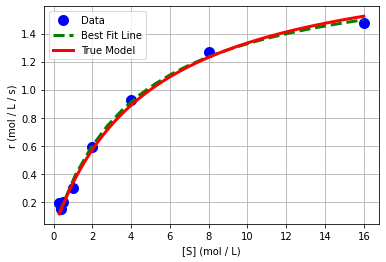

In [14]:
# generate predictions
S_pred = np.linspace(np.min(Sexp),np.max(Sexp),20)
r_pred = model(theta, S_pred)

# create plot
plt.plot(Sexp,rexp,'.b',markersize=20,label='Data')
plt.plot(S_pred,r_pred,'--g',linewidth=3,label='Best Fit Line')
plt.plot(S,r,'r-',linewidth=3,label='True Model')
plt.xlabel('[S] (mol / L)')
plt.ylabel('r (mol / L / s)')
plt.grid(True)
plt.legend()
plt.show()

##### Step 2. Residual Analysis

In [15]:
## calculate residuals
y_hat2 = model(theta,Sexp)
e2 = rexp - y_hat2
print(e2)

[ 0.06665632 -0.01579968  0.00270248 -0.05566205 -0.00926582  0.01646723
  0.03154713 -0.0232116 ]


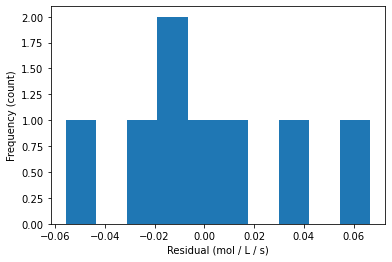

In [16]:
plt.hist(e2)
plt.xlabel("Residual (mol / L / s)")
plt.ylabel("Frequency (count)")
plt.show()

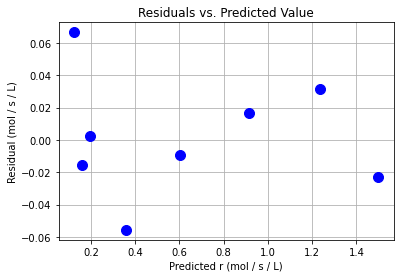

In [18]:
plt.plot(y_hat2,e2,"b.",markersize=20)
plt.xlabel("Predicted r (mol / s / L)")
plt.ylabel("Residual (mol / s / L)")
plt.grid(True)
plt.title("Residuals vs. Predicted Value")
plt.show()

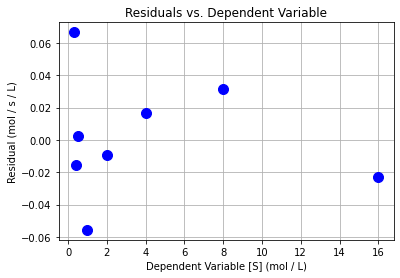

In [19]:
plt.plot(Sexp,e2,"b.",markersize=20)
plt.xlabel("Dependent Variable [S] (mol / L)")
plt.ylabel("Residual (mol / s / L)")
plt.grid(True)
plt.title("Residuals vs. Dependent Variable")
plt.show()

##### Step 3. Uncertainty Analysis / Calculate Covariance Matrix

$$
\Sigma_{\theta} \approx \hat{\sigma}_e^2 (J^T J)^{-1}
$$

where $J$ is the Jacobian of the residuals w.r.t. $\theta$:

$$
J_{i,j} = \frac{\partial(y_i - \hat{y}_i)}{\partial \theta_j}
$$

In [20]:
print("Jacobian =\n")
print(nl_results.jac)

Jacobian =

[[-0.06455816  0.02647355]
 [-0.08426424  0.03382655]
 [-0.10315718  0.04055646]
 [-0.18702173  0.06665232]
 [-0.31511088  0.09460802]
 [-0.47921568  0.109404  ]
 [-0.64793212  0.10000005]
 [-0.78635779  0.0736464 ]]


In [21]:
sigre = (e2.T @ e2)/(len(e2) - 2)
Sigma_theta2 = sigre * np.linalg.inv(nl_results.jac.T @ nl_results.jac)
print("Covariance matrix:\n",Sigma_theta2)

Covariance matrix:
 [[0.00600664 0.03068078]
 [0.03068078 0.19318465]]


#### Nonlinear Regression + Monte Carlo Uncertainty Analysis

**Main Idea**
* Use residuals to estimate uncertainty in dependent variable
* Simulate regression procedure 1000s of times, adding random noise to dependent variable
* Examine distribution of fitted values

In [22]:
# variance of residuals
print(sigre)

0.0016148812853250087


##### Pseudocode

<div style="background-color: rgba(0,0,255,0.05) ; padding: 10px; border: 1px solid darkblue;"> 
<b>Class Activity</b>: Write pseudocode with a partner.
</div>

##### Python Hints

Let's say we want to generate a vector with 5 elements, each normally distributed with mean 0 and standard deviation 2. We can do this in one line using Python:

In [23]:
my_vec = np.random.normal(loc = 0,scale = 2,size=(5))
print(my_vec)

[-2.42110719 -0.21286981  2.10153289 -0.42647601 -1.77003804]


##### Implement in Python

<div style="background-color: rgba(0,0,255,0.05) ; padding: 10px; border: 1px solid darkblue;"> 
<b>Class Activity</b>: Implement your pseudocode in Python.
</div>

In [24]:
# Number of Monte Carlo samples
nmc = 1000;

# Number of data points
n = len(rexp)

# Declare a matrix to save the fitted parameters
theta_mc = np.zeros((nmc,2))

# Recall, the standard deviation of the residuals is sigre**0.5

# Perform Monte Carlo simulation
### BEGIN SOLUTION
# Repeat for i = 0 to nmc - 1
for i in range(nmc):
    
    # generate Guassian random noise with mean 0 and standard deviation of sqrt(sigre)
    noise_vector = np.random.normal(loc = 0,scale = sigre**0.5, \
                                    size=(n))
    
    # add noise to the dependent variable
    noisy_data = rexp + noise_vector
    
    # compute the least squares best fit via nonlinear optimization
    # use the determinist nonlinear regression best fit as a starting point
    sol = optimize.least_squares(regression_func,theta,args=(Sexp, noisy_data))
    
    # save solution
    theta_mc[i,:] = sol.x

### END SOLUTION

##### Visualize Distribution of Fitted Parameters

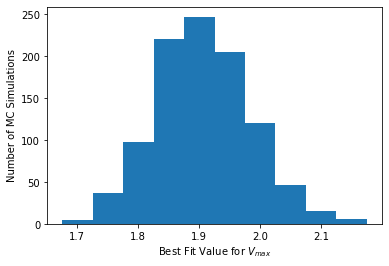

In [25]:
# Histogram for Vmax
plt.hist(theta_mc[:,0])
plt.xlabel("Best Fit Value for $V_{max}$")
plt.ylabel("Number of MC Simulations")
plt.show()

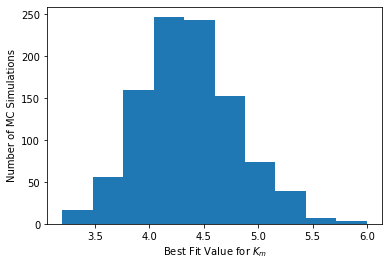

In [26]:
# Histogram for Km
plt.hist(theta_mc[:,1])
plt.xlabel("Best Fit Value for $K_{m}$")
plt.ylabel("Number of MC Simulations")
plt.show()

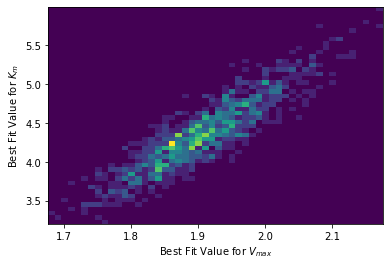

In [27]:
# We can even make a 2D histogram
plt.hist2d(theta_mc[:,0], theta_mc[:,1],bins=50)
plt.xlabel("Best Fit Value for $V_{max}$")
plt.ylabel("Best Fit Value for $K_{m}$")
plt.show()

##### Compute Covariance Matrix

In [28]:
## We can calculate covariance in one, carefully constructed line
# For some reason, the NumPy developers choose to assume each ROW is a new variable
# and each COLUMN is a different observation. I would have choose a flipped convention.
# Our 'theta_mc' has each row as a different observation (simulation).
# 'rowvar=False' tells NumPy to flip its convention. This is a great example of
# WHY YOU SHOULD ALWAYS CHECK THE DOCUMENTATION!!!
np.cov(theta_mc,rowvar=False)

array([[0.00615554, 0.03103356],
       [0.03103356, 0.19341829]])